In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

sys.path.append(os.path.join(os.getcwd(), os.pardir))
from plot import colorPanel, loader, stick
from plot.cd import cd
import glob
import json
import csv
#from plotting import cd
#from plotting import baseline_logger as bl

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

In [2]:
def smooth_reward_curve(x, y):
    print (len(x))
    halfwidth = min(151, int(np.ceil(len(x)/15))) # Halfwidth of our smoothing convolution
    k = halfwidth
    xsmoo = x[k:-k]
    ysmoo = np.convolve(y, np.ones(2*k+1), mode='valid') / np.convolve(np.ones_like(y), np.ones(2*k+1), mode='valid')
    downsample = max(int(np.floor(len(xsmoo)/1e3)),1)
    return xsmoo[::downsample], ysmoo[::downsample]

def process_json(path):
    with open(path, 'r') as f:
        r = {'l': [], 'r': []}
        ccnt = 0
        kk = 0
        ff = 1
        fs = csv.reader(f)
        for line in fs:
            if ff:
                ff = 0
                idx = line.index('AverageReturn_all_test_tasks')
                continue
#             d = json.loads(line)
            kk += 1
#             tmp.append(d['AverageReturn_all_test_tasks'])
            if line[idx] == 'nan':
                break
            r['l'].append(kk)
            r['r'].append(float(line[idx]))
    for k in ['l', 'r']:
        r[k] = np.array(r[k])
    return r


def average_dict(res, keys, er, rr):
    """
    :param res: the dict
    :param keys: keys
    :return: a dict with (key, (mean, std)) of results.
    """
    ret = dict()
    for k in keys:
        vs = [r[k] for r in res]
        l = min(v.shape[0] for v in vs)
        vs = [v[np.newaxis, :l] for v in vs]
        vs = np.concatenate(vs, axis=0)
#         if k == 'r':
#             vs = (vs-rr)/(er-rr)
        m, s = np.median(vs, axis=0), np.std(vs, axis=0, dtype=np.float64)
        ret[k] = [m, s]
    return ret

In [3]:
def get_data(prefix, criterion, er, rr):

    with cd(prefix):
        paths = glob.glob(criterion)
        d = dict()
        print (paths, criterion)
        
        for path in paths:
            files = glob.glob(path + '/*/progress.csv')
            res = []
            for f in files:
                r = process_json(f)
                res.append(r)
#             print (len(res))
            if True:
                res = average_dict(res, ['l', 'r'], er=er, rr=rr)
            d[path] = res
        print ("len is %d"%(len(paths)))
        if len(paths) == 1:
            for k, v in d.items():
                return v
        else:
            return d

In [4]:
def plotArg(game, ax):
    env_id, traj_need = game.split('-')
    traj_need = int(traj_need)
    colors = colorPanel.colorPanel(1).getColors()
    
    dims = [ '4']
    cats = ['5']
    lams = ['10.0']
    cnt = 0
    
    expert_reward = -6.22
    random_reward = -13.46
    for dim in dims:
        for cat in cats:
            for lam in lams:
#                 datas = get_data(prefix='/dfs/scratch2/hyren/intern/projects/nomjco/oyster/cat-new/categorical-point-robot/dim-%s-cat-%s-lam-%s-tem-0.67-ann-False/'%(dim, cat, lam), \
#                              criterion='*', er = expert_reward, rr = random_reward)
                datas = get_data(prefix='/dfs/scratch2/hyren/intern/projects/nomjco/oyster/log-test/test-robot/dim-%s-cat-%s-lam-%s-tem-0.67-ann-False/'%(dim, cat, lam), \
                             criterion='*', er = expert_reward, rr = random_reward)

                label = 'dim-%s-cat-%s-lam-%s-tem-0.67-ann-False'%(dim, cat, lam)

#                 for i in datas:
#                     print (i)
#                 exit(-1)
                x = datas['l']
                y = datas['r']

                x = x[0]
                y_mean = y[0]
                y_std = y[1]

                xx = x
                x, y_mean = smooth_reward_curve(xx, y_mean)
                x, y_std = smooth_reward_curve(xx, y_std)
#                 x = x * 1e7 / np.max(x)

                cnt += 1
                color = colors[cnt]

                y_upper = y_mean + y_std
                y_lower = y_mean - y_std
                ax.fill_between(
                    x, list(y_lower), list(y_upper), interpolate=True, facecolor=color, linewidth=0.0, alpha=0.3
                )
                line = ax.plot(x, list(y_mean), label=label, color=color, rasterized=True)          

    
#     game = 'Cooperative Communication'
#     stick.cutsomStick(game, 'timesteps', ax)
    if args == 'Reacher':
        ax.set_ylim(-10, 0)
    #ax.set_ylim(-70,0)

categorical-40
['seed-1', 'seed-2'] *
len is 2


KeyError: 'l'

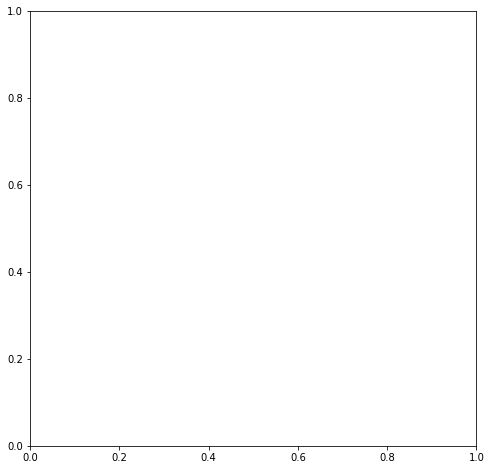

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
columns = 1
sixAtariGames = [
    'categorical-40',
]

#ax.spines['top'].set_color('none')
#ax.spines['bottom'].set_color('none')
#ax.spines['left'].set_color('none')
#ax.spines['right'].set_color('none')
#ax.tick_params(labelcolor='b', top='off', bottom='on', left='on', right='off')


for i, args in enumerate(sixAtariGames):
    print(args)
    #ax = fig.add_subplot(len(sixAtariGames) / columns + 1, columns, i + 1)
    #ax = fig.add_subplot(1, 1, 1)
    plotArg(args, ax)

#plt.legend(loc=4)

lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=4)

ax.set_xlabel('Number of Timesteps')
ax.set_ylabel('Episode Rewards')

fig.tight_layout()
fig.savefig('complexity_listener.pdf', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')